<a href="https://colab.research.google.com/github/jihed01/Churn-Prediction/blob/main/KL_divergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To implement the univariate mixture of Gaussians as shown in the example from the f-GAN paper, and to reproduce the results, you would need to follow these key steps:

1. **Set up the experiment**:
   - You're aiming to approximate a mixture of Gaussians by learning a Gaussian distribution. You'll need to represent your model $ Q_{\theta} $ using a linear function which takes a random $ z $ from a standard normal distribution $ N(0, 1) $\) and outputs $ G_{\theta}(z) = \mu + \sigma z $, where $ \theta = (\mu, \sigma) $ are the parameters to be learned.

2. **Variational function**:
   - Use a neural network with two hidden layers having 64 units each and tanh activations for the variational function $ T_{\omega} $.

3. **Optimization**:
   - Optimize the objective $ F(\omega, \theta) $ using a single-step gradient method. Use mini-batch sampling and an appropriate learning rate (e.g., $ \eta = 0.01 $) for updating both $ \omega $ and $ \theta $.

4. **Training**:
   - Train $ T_{\omega} $ and $ Q_{\theta} $ using various divergence measures like KL, reverse KL, JS, Jeffrey, and Pearson.
   - Sample batches of size 1024 for both $ p(x)$ and $ p(z) $.

5. **Comparison and evaluation**:
   - Compare the learned parameters with the best fit obtained by direct optimization of $ D_{f}(P||Q_{\theta}) $ with respect to $ \theta $, which is feasible by solving the required integrals numerically.
   - Use $ (\hat{\omega}, \hat{\theta}) $ to denote the parameters learned through this process, and $ \theta^{*} $ for the best fit.

6. **Plotting**:
   - You would need to plot the learned distribution against the true distribution to evaluate how well your generative model is performing.

7. **Practical considerations**:
   - Use gradient clipping and optimizers like Adam for stability and efficiency.
   - Monitor the training closely for convergence and adjust hyperparameters as needed.

The results section of the paper suggests that you can expect to see a good correspondence between the gap in objectives and the difference between the fitted means and standard deviations, as well as that the trained model performs best on the divergence it was trained with.

This is a high-level summary. You should ensure to adjust the architecture and training specifics to match your setup and computational resources. Additionally, you might need to perform hyperparameter tuning to achieve the best results.

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR

Initialiser les paramètres du modèle et de la fonction variationnelle :

In [31]:
# Initialisation He pour les poids
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

class GenerativeModel(nn.Module):
    def __init__(self):
        super(GenerativeModel, self).__init__()
        self.mu = nn.Parameter(torch.randn(1) * 0.1)
        self.log_sigma = nn.Parameter(torch.randn(1) * 0.1)

    def forward(self, z):
        return self.mu + torch.exp(self.log_sigma) * z

class VariationalFunction(nn.Module):
    def __init__(self):
        super(VariationalFunction, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
        self.network.apply(init_weights)

    def forward(self, x):
        return self.network(x).squeeze(1)

def sample_mixture_gaussians(batch_size, w, m1, v1, m2, v2):
    n_samples_first = int(batch_size * w)
    n_samples_second = batch_size - n_samples_first
    samples_first = torch.randn(n_samples_first, 1) * torch.sqrt(torch.tensor(v1)) + m1
    samples_second = torch.randn(n_samples_second, 1) * torch.sqrt(torch.tensor(v2)) + m2
    return torch.cat([samples_first, samples_second], dim=0)

def kl_divergence(x_real, x_fake, T_omega):
    t_real = T_omega(x_real)
    t_fake = T_omega(x_fake)
    kl_loss = torch.mean(t_real) - torch.mean(torch.exp(t_fake - t_fake.max()))  # stabilisation
    return kl_loss

# Paramètres du mélange de gaussiennes
w, m1, v1, m2, v2 = 0.67, -1, 0.0625, 2, 2

# Définition de la grille d'hyperparamètres
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [512, 1024, 2048],
    'num_epochs': [1000, 5000, 10000]
}

# Création de la grille d'hyperparamètres
grid = list(ParameterGrid(param_grid))

# Initialisation des variables pour stocker le meilleur modèle
best_loss = np.inf
best_params = None
best_model_state = None

# Boucle sur toutes les combinaisons de la grille d'hyperparamètres
for params in grid:
    print(f"Training with params: {params}")

    # Initialisation des modèles et des optimiseurs
    G = GenerativeModel()
    T = VariationalFunction()
    optimizer_G = optim.Adam(G.parameters(), lr=params['learning_rate'])
    optimizer_T = optim.Adam(T.parameters(), lr=params['learning_rate'])

    # Annealing du taux d'apprentissage
    scheduler_G = ExponentialLR(optimizer_G, gamma=0.9)
    scheduler_T = ExponentialLR(optimizer_T, gamma=0.9)

    # Boucle d'entraînement
    for epoch in range(params['num_epochs']):
        x_real = sample_mixture_gaussians(params['batch_size'], w, m1, v1, m2, v2)
        z = torch.randn(params['batch_size'], 1)
        x_fake = G(z)

        optimizer_T.zero_grad()
        loss_T = kl_divergence(x_real, x_fake.detach(), T)
        loss_T.backward()
        optimizer_T.step()

        optimizer_G.zero_grad()
        loss_G = kl_divergence(x_real, x_fake, T)
        (-loss_G).backward()
        optimizer_G.step()

        # Mise à jour du taux d'apprentissage
        if epoch % 1000 == 0:
            scheduler_G.step()
            scheduler_T.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss_T = {loss_T.item()}, Loss_G = {loss_G.item()}")

    final_loss = loss_G.item()  # Utilisation de loss_G comme critère d'évaluation

    if final_loss < best_loss:
        best_loss = final_loss
        best_params = params
        best_model_state = {
            'G_state_dict': G.state_dict(),
            'T_state_dict': T.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_T_state_dict': optimizer_T.state_dict(),
            'loss': best_loss,
            'params': best_params
        }
        torch.save(best_model_state, 'best_model.pth')

print(f"Best Loss: {best_loss}")
print(f"Best Hyperparameters: {best_params}")


Training with params: {'batch_size': 512, 'learning_rate': 0.001, 'num_epochs': 1000}
Epoch 0: Loss_T = 0.0766449123620987, Loss_G = 0.02300504595041275
Epoch 100: Loss_T = -1.1129741668701172, Loss_G = -1.2127169370651245
Epoch 200: Loss_T = -4.586388111114502, Loss_G = -4.50886344909668
Epoch 300: Loss_T = -10.7691011428833, Loss_G = -11.137742042541504
Epoch 400: Loss_T = -19.737993240356445, Loss_G = -20.00797462463379
Epoch 500: Loss_T = -31.7608585357666, Loss_G = -31.75788688659668
Epoch 600: Loss_T = -46.416561126708984, Loss_G = -46.42390823364258
Epoch 700: Loss_T = -62.44626998901367, Loss_G = -64.31195831298828
Epoch 800: Loss_T = -82.93164825439453, Loss_G = -82.40505981445312
Epoch 900: Loss_T = -103.87023162841797, Loss_G = -107.03396606445312
Training with params: {'batch_size': 512, 'learning_rate': 0.001, 'num_epochs': 5000}
Epoch 0: Loss_T = -0.022651832550764084, Loss_G = -0.1818065196275711
Epoch 100: Loss_T = -1.4270505905151367, Loss_G = -1.491921067237854
Epoch 

In [32]:
learned_mu = G.mu.item()
learned_sigma = torch.exp(G.log_sigma).item()

print("μ̂ :", learned_mu)
print("σ̂ :", learned_sigma)


μ̂ : -3.534200668334961
σ̂ : 0.17280687391757965


In [33]:
mu_optimal= 1.0099984454639233
sigma_optimal=1.8304447165750592

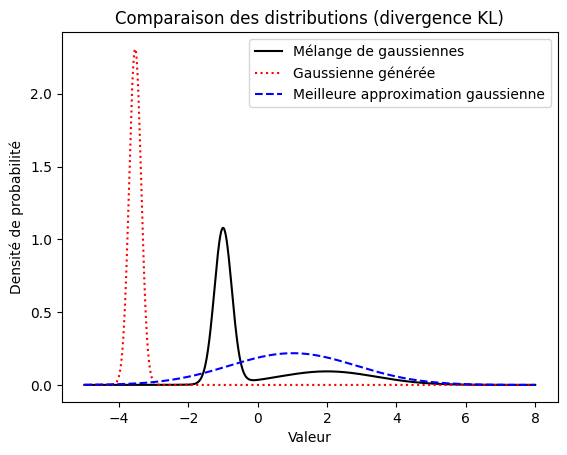

In [34]:
from scipy.stats import norm

# Les valeurs pour l'axe des x
x_axis = np.linspace(-5, 8, 1000)

# La densité de probabilité du mélange de gaussiennes
density_mixture = w * norm.pdf(x_axis, m1, np.sqrt(v1)) + (1 - w) * norm.pdf(x_axis, m2, np.sqrt(v2))

# Supposons que les densités apprises et la meilleure approximation soient les suivantes :

learned_density = norm.pdf(x_axis, learned_mu, learned_sigma)

# La densité de la gaussienne optimale
optimal_density = norm.pdf(x_axis, mu_optimal, sigma_optimal)


# Dessiner la densité de probabilité du mélange de gaussiennes
plt.plot(x_axis, density_mixture, label='Mélange de gaussiennes', color='black')

# Dessiner la densité apprise
plt.plot(x_axis, learned_density, label='Gaussienne générée', linestyle=':', color='red')

# Tracer la densité optimale
plt.plot(x_axis, optimal_density, label='Meilleure approximation gaussienne', linestyle='--', color='blue')

# Ajouter des légendes et des titres
plt.title('Comparaison des distributions (divergence KL)')
plt.xlabel('Valeur')
plt.ylabel('Densité de probabilité')
plt.legend()

# Afficher le graphique
plt.show()
